# Sentiment analysis using Simple RNN

*Sentiment Analysis is the process of determining whether a piece of text is positive, negative, or neutral. It is widely used in social media monitoring, customer feedback and support, identification of derogatory tweets, product analysis, etc. Here we are going to build a Bidirectional RNN network to classify a sentence as either positive or negative using the IMDB dataset*

In [1]:
# Importing the packages
import re
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.layers import  Dense, SimpleRNN, LSTM, GRU, Embedding, SpatialDropout1D
# from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import backend 



In [20]:
# Importing the Dataset
df = pd.read_csv("Data/IMDB Dataset.csv")

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [22]:
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [23]:
df.columns

Index(['review', 'sentiment'], dtype='object')

## Data Preprocessing

In [24]:
#removing the html
def clean_html(text):
    clean =re.compile('<.*?>')
    clean_text = re.sub(clean, '', text)
    return clean_text

In [25]:
# first round of cleaning
def clean_text1(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]'%re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '' , text)
    return text

In [26]:
# second round of cleaning
def clean_text2(text):
    text = re.sub('['',"",,,]', '' ,text)
    text = re.sub('\n', '', text)
    return text

In [27]:
df['review_cleaned'] = pd.DataFrame(df.review.apply(lambda x : clean_html(x)))

In [28]:
df['review_cleaned'] = pd.DataFrame(df.review_cleaned.apply(lambda x : clean_text1(x)))
df['review_cleaned'] = pd.DataFrame(df.review_cleaned.apply(lambda x : clean_text2(x)))


In [11]:
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [12]:
df['sentiment']= df['sentiment'].replace({'positive': 1, 'negative': 0})

In [13]:
df.head(5)

,review,sentiment,review_cleaned
0,One of the other reviewers has mentioned that ...,1,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,1,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,1,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,0,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter matteis love in the time of money is a ...


## Defining the model


In [14]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trun_type = 'post'

num_epochs = 30

*The text data is first tokenized using the Tokenizer class from Keras.*
- The Tokenizer converts the text data into sequences of integer values, where each integer represents a specific word in the vocabulary

In [15]:
tokenizer = Tokenizer(num_words= vocab_size, split= ' ')
tokenizer.fit_on_texts(df['review_cleaned'].values)

*After tokenization, the text data is then padded to ensure that all sequences have the same length using the pad_sequences function from Keras.*
- This is necessary because the RNN model expects inputs of the same length

In [16]:
X = tokenizer.texts_to_sequences(df['review_cleaned'].values)
X= pad_sequences(X, maxlen= max_length, truncating= trun_type)

In [17]:
len(X[10])

120

In [29]:
Y = pd.get_dummies(df['sentiment'])

In [30]:
result_dict = {0: 'Negative', 1: 'Positive'}
y_arr = np.vectorize(result_dict.get)(Y.columns)


In [31]:
Y = Y.values


In [32]:
Y

array([[False,  True],
       [False,  True],
       [False,  True],
       ...,
       [ True, False],
       [ True, False],
       [ True, False]])

*Once the text data has been tokenized and padded, it is passed to the RNN model, which uses an `Embedding layer` to convert each integer value in the input sequences to a dense vector representation.*
- The `Embedding layer` learns a low-dimensional representation of each word in the vocabulary based on its co-occurrence patterns in the input text data.
- The output of the Embedding layer is then passed to the `SimpleRNN layer`, which applies a simple recurrent neural network to the sequence of input vectors.
- The `SimpleRNN layer` maintains a hidden state that is updated at each time step based on the current input and the previous hidden state.
- The output of the `SimpleRNN layer` is a single vector representation of the input sequence, which can be used for classification or other downstream tasks
-Finally, the output of the `SimpleRNN layer` is passed to a `Dense layer` with a **softmax activation** function, which outputs a probability distribution over the two possible classes.

In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length= max_length),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(10, activation= 'relu'),
    tf.keras.layers.Dense(2, activation= 'sigmoid')

])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                1568      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
 dense_3 (Dense)             (None, 2)                 22        
                                                                 
Total params: 161920 (632.50 KB)
Trainable params: 161920 (632.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


*The model is trained using categorical cross-entropy loss and optimized using the Adam optimizer.*

In [38]:
model.compile(loss = 'categorical_crossentropy', optimizer= 'adam',
              metrics = ['accuracy'])

## Splitting the dataset

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size= 0.2, stratify= Y, random_state= 317)

In [34]:
X_train.shape, y_train.shape

((40000, 120), (40000, 2))

In [ ]:
X_test.shape, y_test.shape

In [39]:
history = model.fit(X_train,y_train, 
                    epochs= num_epochs,
                    validation_data = (X_test, y_test)
                    )

Epoch 1/30
1250/1250 [==============================] - 34s 24ms/step - loss: 0.6935 - accuracy: 0.5058 - val_loss: 0.6932 - val_accuracy: 0.4938
Epoch 2/30
1250/1250 [==============================] - 28s 23ms/step - loss: 0.6770 - accuracy: 0.5567 - val_loss: 0.6660 - val_accuracy: 0.5888
Epoch 3/30
1250/1250 [==============================] - 29s 23ms/step - loss: 0.5594 - accuracy: 0.7154 - val_loss: 0.4624 - val_accuracy: 0.7880
Epoch 4/30
1250/1250 [==============================] - 28s 22ms/step - loss: 0.4301 - accuracy: 0.8116 - val_loss: 0.4344 - val_accuracy: 0.8064
Epoch 5/30
1250/1250 [==============================] - 29s 23ms/step - loss: 0.3747 - accuracy: 0.8428 - val_loss: 0.4117 - val_accuracy: 0.8153
Epoch 6/30
1250/1250 [==============================] - 31s 24ms/step - loss: 0.3333 - accuracy: 0.8647 - val_loss: 0.4274 - val_accuracy: 0.8067
Epoch 7/30
1250/1250 [==============================] - 31s 24ms/step - loss: 0.3046 - accuracy: 0.8774 - val_loss: 0.4305 -

In [40]:
def plot_graph_stats(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("num_epochs")
    plt.ylabel(string)
    plt.legend([string, 'val'+string])
    plt.show()


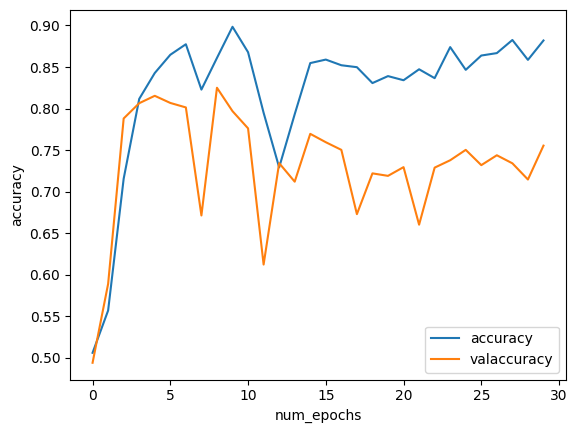

In [41]:
plot_graph_stats(history, 'accuracy')

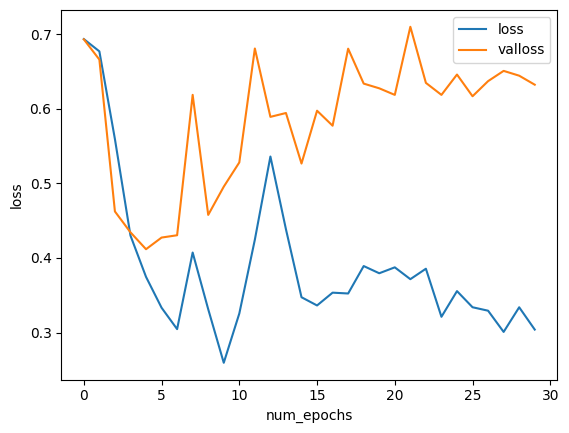

In [42]:
plot_graph_stats(history, 'loss')